In [14]:
import sys
import os
sys.path.insert(0, os.path.dirname(os.getcwd()))
from config import *

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
import time

from keras import backend as K

In [17]:
# standardization
# mean is computed only over the training data and then subtracted equally from all splits
scaler = StandardScaler().fit(X_train)
X_train = (X_train - scaler.mean_) / np.sqrt(scaler.var_)
X_test = (X_test - scaler.mean_) / np.sqrt(scaler.var_)

In [32]:
K.clear_session()
model = Sequential()
model.add(Dense(30, activation='relu', name="hidden_1", input_dim=X_train.shape[1]))
model.add(Dense(40, activation='relu', name="hidden_2"))
model.add(Dense(1, activation='sigmoid', name="op"))
model.compile(optimizer=Adam(lr=1e-2), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_split=0.2, epochs=80, batch_size=512, verbose=0)
roc_auc_score(y_test, model.predict_proba(X_test))

0.9418417133594978

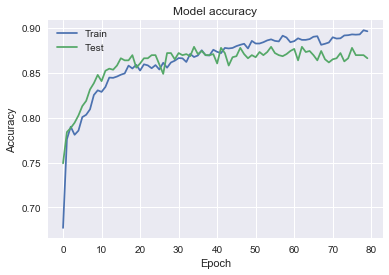

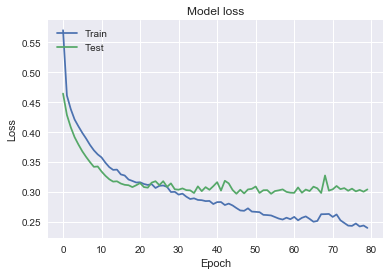

In [33]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [34]:
def learning_curve_nn(X, y, cv=None, train_size=None):
    lc_train = [] 
    lc_cv = []

    cut_points = np.round(train_size * X.shape[0]).astype(int)
    for cp in cut_points:
        X_sample = X.iloc[:cp]
        y_sample = y.iloc[:cp]
        train_scores = []
        cv_scores = []
        for train_idx, val_idx in cv.split(X_sample, y_sample):
            xtrain, xval = X_sample.iloc[train_idx], X_sample.iloc[val_idx]
            ytrain, yval = y_sample.iloc[train_idx], y_sample.iloc[val_idx]

            K.clear_session()
            model = Sequential()
            model.add(Dense(30, activation='relu', name="hidden_1", input_dim=X_train.shape[1]))
            model.add(Dense(40, activation='relu', name="hidden_2"))
            model.add(Dense(40, activation='relu', name="hidden_3"))
            model.add(Dense(1, activation='sigmoid', name="op"))
            model.compile(optimizer=Adam(lr=1e-2), loss='binary_crossentropy')
            history = model.fit(xtrain, ytrain, epochs=80, batch_size=512, shuffle=True, verbose=0)
            
            fold_train_score = roc_auc_score(ytrain, model.predict_proba(xtrain))
            fold_cv_score = roc_auc_score(yval, model.predict_proba(xval))


            train_scores.append(fold_train_score)
            cv_scores.append(fold_cv_score)

        lc_train.append(train_scores)
        lc_cv.append(cv_scores)
    return train_size, np.array(lc_train), np.array(lc_cv)

In [35]:
def plot_learning_curve_nn(title, X, y, ylim=None, cv=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel('roc_auc_score')

    train_sizes, train_scores, test_scores = learning_curve_nn(X, y, cv=cv, train_size=train_sizes)
    
    print(train_scores)
    print(test_scores)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid(linewidth=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

[[0.99747996 0.99364226 0.99100112 0.99627677 0.99911739 0.99694612
  0.99801169 0.99729797 0.99820408 0.99887048]
 [0.97351608 0.97183356 0.97646287 0.97503086 0.96632333 0.97446229
  0.96786664 0.97091049 0.96923299 0.97643256]
 [0.97838097 0.97432886 0.9722327  0.98011927 0.9791722  0.98063187
  0.97220505 0.97799393 0.97794094 0.9711013 ]
 [0.97089854 0.97511846 0.96729637 0.9617978  0.97078468 0.96934676
  0.96872786 0.96496524 0.96664973 0.97024309]
 [0.97075711 0.97427311 0.97192519 0.97889127 0.9760131  0.97415614
  0.97613192 0.96989106 0.97301433 0.97535763]]
[[0.88383152 0.90435835 0.89035088 0.87       0.87681159 0.84451613
  0.88544776 0.90608466 0.7950938  0.83903226]
 [0.9230359  0.90746096 0.94030899 0.9118068  0.93250434 0.91378641
  0.89558405 0.92581992 0.90678287 0.89352227]
 [0.89741896 0.92731424 0.94850356 0.92748995 0.90252766 0.91697125
  0.92479892 0.92391582 0.89442247 0.93266954]
 [0.92322368 0.93641173 0.93356363 0.92348282 0.92132994 0.91233213
  0.9185081

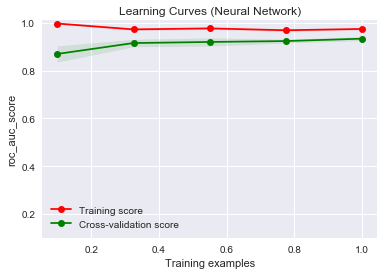

In [36]:
title = "Learning Curves (Neural Network)"
seed = 0
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=1)

start = time.time()
plot_learning_curve_nn(title, X_train, y_train, ylim=(0.1, 1.01), cv=cv)
print(time.time() - start)


In [6]:
args_dict = {'hidden_layer_sizes': 10, 
             'activation': 'relu', 
             'solver': 'adam', 
             'alpha': 1e-2, 
             'batch_size': 128, 
             'learning_rate_init': 0.001, 
             'max_iter': 300, 
             'shuffle': True, 
             'tol': 1e-4, 
             'verbose': False,
             'early_stopping': False,
             'validation_fraction': 0.2   # default 0.1
            }

clf = MLPClassifier(**args_dict)
title = "Learning Curves (Neural Nets)"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=1)
plot_learning_curve(clf, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, metric=roc_auc_score, n_jobs=4)